In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import string
import cv2

/Users/mac/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mac/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mac/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mac/Applications/anaconda3/lib/python3.7/s

In [2]:
# 导入函数
from model import captcha_model
from getData import gen

# 设置参数
from params import *

In [3]:
model = captcha_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 120, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 118, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 116, 32)       9248      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 76, 116, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 58, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 56, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 54, 64)        36928     
__________

In [5]:
# 消除found libiomp5.dylib already initialized 错误
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
#设置回调函数
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

checkpointer_best = ModelCheckpoint(filepath = "log/model_best.h5", verbose = 1, save_best_only = True)

checkpointer_normal = ModelCheckpoint(filepath = "log/model.h5", verbose = 1, save_best_only = False)

logger  = CSVLogger('log/training.log', append = True)

callbacks = [checkpointer_best, checkpointer_normal, logger]

# 训练模型
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [7]:
# 加载模型
from tensorflow.keras.models import load_model
# model = load_model('log/model.h5')

# 训练模型
log = model.fit(gen(trainDir),
                          steps_per_epoch=125,
                          epochs=50,
                          workers=1,
                          validation_data=gen(valDir),
                          validation_steps=30,
                          callbacks=callbacks,
                          shuffle=False,
                          initial_epoch=0)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
30/30 [==============================] - 14s 477ms/step - loss: 4.2681 - acc: 0.0185

Epoch 00001: val_loss improved from inf to 4.26806, saving model to log/model_best.h5

Epoch 00001: saving model to log/model.h5
125/125 [==============================] - 185s 1s/step - loss: 5.0772 - acc: 0.0256 - val_loss: 4.2681 - val_acc: 0.0185
Epoch 2/1000
30/30 [==============================] - 14s 480ms/step - loss: 4.3101 - acc: 0.0216

Epoch 00002: val_loss did not improve from 4.26806

Epoch 00002: saving model to log/model.h5
125/125 [==============================] - 197s 2s/step - loss: 4.2328 - acc: 0.0737 - val_loss: 4.3101 - val_acc: 0.0216
Epoch 3/1000
30/30 [==============================] - 13s 418ms/step - loss: 3.6971 - acc: 0.0935

Epoch 00003: val_loss improved from 4.26806 to 3.69709, saving model to log/model_best.h5

Epoch 00003: saving model to log/model.h5
125/125 [==============================] - 197s 2s/step

125/125 [==============================] - 148s 1s/step - loss: 0.1083 - acc: 0.9722 - val_loss: 0.1894 - val_acc: 0.9523
Epoch 24/1000
30/30 [==============================] - 11s 368ms/step - loss: 0.2155 - acc: 0.9464

Epoch 00024: val_loss did not improve from 0.18940

Epoch 00024: saving model to log/model.h5
125/125 [==============================] - 143s 1s/step - loss: 0.0944 - acc: 0.9753 - val_loss: 0.2155 - val_acc: 0.9464
Epoch 25/1000
30/30 [==============================] - 11s 380ms/step - loss: 0.2345 - acc: 0.9427

Epoch 00025: val_loss did not improve from 0.18940

Epoch 00025: saving model to log/model.h5
125/125 [==============================] - 144s 1s/step - loss: 0.0802 - acc: 0.9780 - val_loss: 0.2345 - val_acc: 0.9427
Epoch 26/1000
30/30 [==============================] - 11s 366ms/step - loss: 0.1832 - acc: 0.9542

Epoch 00026: val_loss improved from 0.18940 to 0.18319, saving model to log/model_best.h5

Epoch 00026: saving model to log/model.h5
125/125 [====

KeyboardInterrupt: 

In [ ]:
# log.history

In [8]:
model.save('log/model.h5')

In [38]:
def decode(y):

    # 找出最大概率
    y = np.argmax(np.array(y),axis=2)[0]
    
    return ''.join([characters[x] for x in y])

def test():
    # 读取图片
    imgBuffer = cv2.imread(testDir+'/23.png', 0)
    # 调整大小
    imgBuffer = cv2.resize(imgBuffer, (width, height))

    plt.imshow(imgBuffer, cmap = 'gray')
    plt.show()
    # 拓展维度
    imgBuffer = np.expand_dims(imgBuffer, axis = 0)
    imgBuffer = np.expand_dims(imgBuffer, axis = 3)
    
    # 对比度拉伸
    minX = imgBuffer.min()
    imgBuffer = imgBuffer - minX
    maxX = max(1, imgBuffer.max())
    # 将对比度拉伸到0-255范围内
#     imgBuffer = np.array(imgBuffer * (255 / maxX), np.uint8)
    imgBuffer = np.array(imgBuffer / maxX, np.float16)
    
    # 返回结果
    return decode(model.predict(imgBuffer))

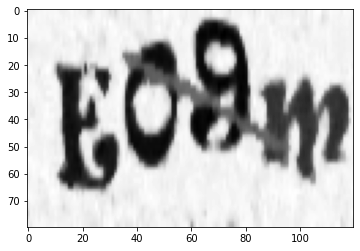

'E09m'

In [39]:
test()

In [60]:
from tqdm import tqdm
def evaluate(model, batch_num=30):
    batch_acc = 0
    generator = gen(valDir)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2)
        y_true = np.argmax(y, axis=2)
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred)))
    return batch_acc / batch_num

In [61]:
evaluate(model)

100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


0.878125